In [1]:
!pip install torch gymnasium ale-py
!pip install torch torchvision gymnasium[atari] ale-py opencv-python numpy matplotlib
!pip install gymnasium[atari] ale-py opencv-python
!pip install gymnasium[accept-rom-license]
import ale_py
ale_py.import_roms('path_to_roms_folder')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.2
    Uninstalling ale-py-0.10.2:
      Successfully uninstalled ale-py-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.8 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for 

AttributeError: module 'ale_py' has no attribute 'import_roms'

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2
import matplotlib.pyplot as plt
import ale_py
ale = ale_py.ALEInterface()


In [3]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized / 255.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class FrameStack:
    def __init__(self, num_frames):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)

    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.extend([processed_frame] * self.num_frames)
        return np.stack(self.frames, axis=0)

    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)


In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._feature_size(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def _feature_size(self, shape):
        o = self.conv1(torch.zeros(1, *shape))
        o = self.conv2(o)
        o = self.conv3(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)


In [7]:
def select_action(state, policy_net, epsilon, num_actions):
    if random.random() > epsilon:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state)
            return q_values.max(1)[1].item()
    else:
        return random.randrange(num_actions)


In [8]:
def optimize_model(policy_net, target_net, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    current_q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values, expected_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Episode 1, Total reward: 0.0, Epsilon: 1.00
Episode 2, Total reward: 0.0, Epsilon: 1.00
Episode 3, Total reward: 1.0, Epsilon: 1.00
Episode 4, Total reward: 0.0, Epsilon: 1.00
Episode 5, Total reward: 0.0, Epsilon: 1.00
Episode 6, Total reward: 1.0, Epsilon: 1.00
Episode 7, Total reward: 1.0, Epsilon: 1.00
Episode 8, Total reward: 0.0, Epsilon: 1.00
Episode 9, Total reward: 0.0, Epsilon: 1.00
Episode 10, Total reward: 1.0, Epsilon: 1.00


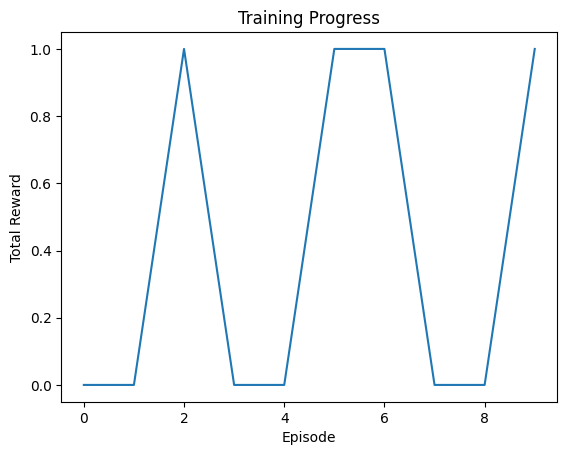

In [9]:
env = gym.make('ALE/WordZapper-v5', render_mode='rgb_array')
num_actions = env.action_space.n
input_shape = (4, 84, 84)

policy_net = DQN(input_shape, num_actions)
target_net = DQN(input_shape, num_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(10000)
frame_stack = FrameStack(4)

num_episodes = 10
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 1000000
epsilon = epsilon_start
target_update = 10

episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = frame_stack.reset(state)
    total_reward = 0

    while True:
        action = select_action(state, policy_net, epsilon, num_actions)
        next_state, reward, done, _, _ = env.step(action)
        next_state = frame_stack.step(next_state)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        optimize_model(policy_net, target_net, optimizer, replay_buffer, batch_size, gamma)
        if done:
            episode_rewards.append(total_reward)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / epsilon_decay)
    print(f"Episode {episode + 1}, Total reward: {total_reward}, Epsilon: {epsilon:.2f}")

env.close()

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()